# Import Example Data Sets

In [1]:
import sys
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = [16 / 1.5, 10 / 1.5]   # inch / cm = 2.54
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
# plt.rcParams['savefig.frameon'] = False
from math import *

The library **sampledata** provides a number of datasets as pandas dataframes. 

In [2]:
import exampledata

## Periodic Sine Curves with Noise

sine_data() provides a sine curve with given period and amplitude, distorted with random noise (with given distribution). 

We get two dataframes - a complete one to plot the true population, and 25 random samples representing noisy measurements:

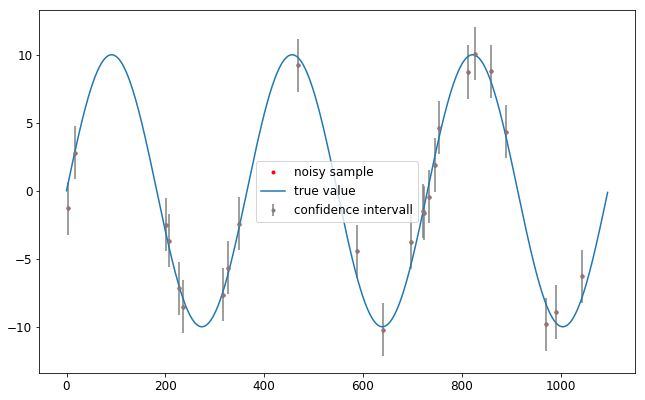

In [3]:
df_all = exampledata.sine_data()
df_z = exampledata.sine_data(n_sample=25)

plt.plot(df_z.x, df_z.measurement, '.', label='noisy sample', color = "red")
plt.plot(df_all.x, df_all.true, label="true value")
plt.errorbar(df_z.x, df_z.measurement, df_z.confidence95, fmt='.',
             label='confidence intervall', color="grey")

plt.legend()
plt.show()

a number of parameters can be used to obtain different datasets, see below (here, the sample is taken afterwards for better code readability).

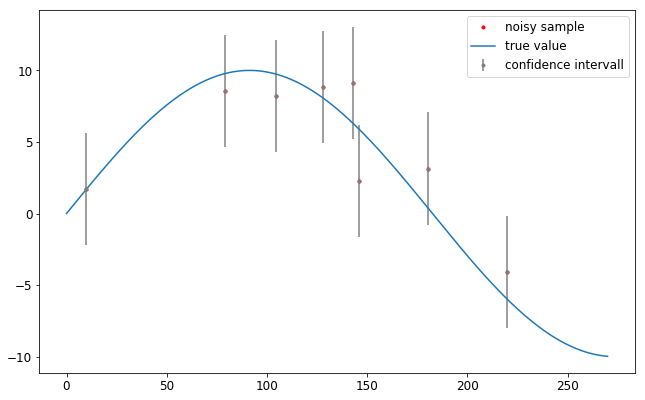

In [9]:
df_all = exampledata.sine_data(start = 0,  stop = 270,  # intervall for predictor
              resolution = 500,   # number of samples to create in interval
              period = 500, amplitude = 10,  # shape of sine curve 
              noise_type="gaussian",   # type of noise
              noise_mean = 0,  # mean of noise
              noise_std = 2)  # standard deviation of noise

df_z = df_all.sample(8)

plt.plot(df_z.x, df_z.measurement, '.', label='noisy sample', color = "red")
plt.plot(df_all.x, df_all.true, label="true value")
plt.errorbar(df_z.x, df_z.measurement, df_z.confidence95, fmt='.',
             label='confidence intervall', color="grey")

df_z.to_excel(r".\example_data\Periodic Sine\example_4.xlsx")

plt.legend()
plt.show()

## Storing and Modifying Data

The dataframe can be saved (see cell above), and later be loaded again.
The following table ist a concanenated dataset for Example 2, with measurements of different confidence intervals.

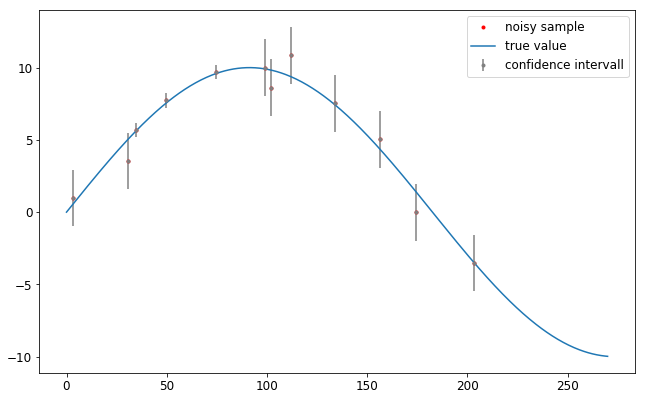

In [12]:
df_z = pd.read_excel(r".\example_data\Periodic Sine\example_2_modified.xlsx")

plt.plot(df_z.x, df_z.measurement, '.', label='noisy sample', color = "red")
plt.plot(df_all.x, df_all.true, label="true value")
plt.errorbar(df_z.x, df_z.measurement, df_z.confidence95, fmt='.',
             label='confidence intervall', color="grey")

plt.legend()
plt.show()